# Projecting WRF data

This notebook creates the coordinate reference system info for a single WRF file using the standard WRF geogrid file (`geo_em.d01.nc`) associated with the particular runs. The WRF data here are from the 1km runs done for the SERDP Fish and Fire project. This notebook draws heavily on [this blog post: "Map projections in WRF: it's easy to get it wrong" by Fabien Maussion](https://fabienmaussion.info/2018/01/06/wrf-projection/) for achieving the desired outcome - thank you Fabien!

## Workflow:

Load libraries and read WRF geogrid file:

In [1]:
import numpy as np
import xarray as xr
from pyproj import Proj, Transformer
from pyproj.crs import CRS

In [2]:
# SERDP WRF geogrid file
geo_ds = xr.open_dataset("/atlas_scratch/kmredilla/WRF/serdp/geo_em.d01.nc")

Create the projection info fro reprojecting lat/lon of WRF grid centerpoint to WRF CRS:

In [3]:
# create the WRF projection
wrf_proj = Proj(
    proj="lcc", # projection type: Lambert Conformal Conic
    lat_1=geo_ds.TRUELAT1, lat_2=geo_ds.TRUELAT2, # Cone intersects with the sphere
    lat_0=geo_ds.MOAD_CEN_LAT, lon_0=geo_ds.STAND_LON, # Center point
    a=6370000, b=6370000 # This is it! The Earth is a perfect sphere
) 
# WGS 
wgs_proj = Proj(proj='latlong', datum='WGS84')

Generate the coordinates in WRF grid space from the centerpoint:

Note - this notebook makes use of `pyproj v2.x` and `pyproj.transformer.Transformer`, unlike the original post linked above. 

In [4]:
transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# Easting and Northings of the domains center point
e, n = transformer.transform(geo_ds.CEN_LON, geo_ds.CEN_LAT)
# Grid parameters
dx, dy = geo_ds.DX, geo_ds.DY
nx, ny = geo_ds.dims['west_east'], geo_ds.dims['south_north']
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# 2d grid
xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)

View the generated coordinates:

In [5]:
print(xx)
print("\nShape: ", xx.shape)

[[105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 ...
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]]

Shape:  (209, 339)


In [6]:
print(yy)
print("\nShape: ", xx.shape)

[[-94340.95982198 -94340.95982198 -94340.95982198 ... -94340.95982198
  -94340.95982198 -94340.95982198]
 [-93340.95982198 -93340.95982198 -93340.95982198 ... -93340.95982198
  -93340.95982198 -93340.95982198]
 [-92340.95982198 -92340.95982198 -92340.95982198 ... -92340.95982198
  -92340.95982198 -92340.95982198]
 ...
 [111659.04017802 111659.04017802 111659.04017802 ... 111659.04017802
  111659.04017802 111659.04017802]
 [112659.04017802 112659.04017802 112659.04017802 ... 112659.04017802
  112659.04017802 112659.04017802]
 [113659.04017802 113659.04017802 113659.04017802 ... 113659.04017802
  113659.04017802 113659.04017802]]

Shape:  (209, 339)


Re-compute the lats and lons for a quick validation:

In [7]:
transformer = Transformer.from_proj(wrf_proj, wgs_proj)

our_lons, our_lats = transformer.transform(xx, yy)

arr = np.sqrt((our_lons - geo_ds.XLONG_M)**2 + (our_lats - geo_ds.XLAT_M)**2)

View the error between the re-computed lats and lons and original lats/lons:

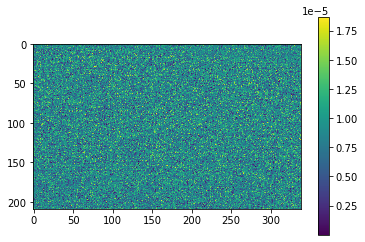

In [8]:
import matplotlib.pyplot as plt

plt.imshow(arr[0], interpolation="none")
plt.colorbar()

Error looks good - white noise! 

Now, load in a file to add these coordinates to:

In [9]:
# sample WRF file provided by Peter
wrf_ds = xr.open_dataset("t2_1km_2008-17_dera_climo.nc")

Assign the coordinates to the xarray dataset:

In [10]:
# rename dims and assign new coords
new_ds = wrf_ds.rename_dims({"south_north": "y", "west_east": "x"})
new_ds = new_ds.assign_coords({"y": ("y", yy[:,0]), "x": ("x", xx[0,:])})

Plot a sample slice:

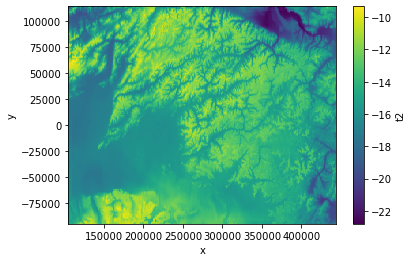

In [11]:
new_ds.t2.sel(time=1).plot()

And write the file:

In [12]:
new_ds.to_netcdf("t2_1km_2008-17_dera_climo_projected.nc")